<a href="https://colab.research.google.com/github/BaronVonBussin/NewTransit/blob/main/regimeswitching_20241224.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 10.6 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import math
from pykalman import KalmanFilter
from matplotlib import pyplot as plt
#% matplotlib inline

In [22]:
# Set last day of in-sample period as Dec 31st 2016
in_sample_last = '2016-12-31'
in_sample_last_minus_half_year = '2016-07-01'

# Read S&P 500 VIX Futures close price
vx = pd.read_csv('/content/S&P 500 VIX Futures Data.csv', index_col=0)
vx.index = pd.to_datetime(vx.index)
vx = vx.iloc[::-1]
vx_close = vx['Price']

# Read S&P 500 Futures close price
sp = pd.read_csv('/content/S&P 500 Futures Daily.csv', index_col=0)
sp.index = pd.to_datetime(sp.index)
sp = sp.iloc[::-1]
for idx, value in sp.iterrows():
    sp['Price'][idx] = value['Price'].replace(',', '')
sp_close = sp['Price']
sp_close = sp_close.astype('float64')

# Concatenate to form close price dataframe 'close_df'
close_df = pd.concat([vx_close, sp_close], axis=1)
close_df.columns = ['vx_close', 'sp_close']
close_df = close_df.interpolate(method='linear')
vx_close = close_df['vx_close']
sp_close = close_df['sp_close']

# Calculate daily return for S&P 500 VIX Futures using close price
vx_return = close_df['vx_close'].pct_change()
vx_return = vx_return.dropna()
vx_return.name = "vx_return"

# Calculate daily return for S&P 500 Futures using close price
sp_return = close_df['sp_close'].pct_change()
sp_return = sp_return.dropna()
sp_return.name = "sp_return"

# Create in-sample dataframe for close prices and returns for both VX and SP
vx_close_is = vx_close[vx_close.index <= in_sample_last]
vx_return_is = vx_return[vx_return.index <= in_sample_last]
sp_close_is = sp_close[sp_close.index <= in_sample_last]
sp_return_is = sp_return[sp_return.index <= in_sample_last]

# Create out-of-sample dataframe for close prices and returns for both VX and SP
vx_close_os = vx_close[vx_close.index > in_sample_last]
vx_return_os = vx_return[vx_return.index > in_sample_last]
sp_close_os = sp_close[sp_close.index > in_sample_last]
sp_return_os = sp_return[sp_return.index > in_sample_last]

print(vx_return_os.head())
print('')
print(sp_return_os.head())

<ipython-input-22-43b66902495a>:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  sp['Price'][idx] = value['Price'].replace(',', '')


2017-01-03   -0.084758
2017-01-04   -0.077821
2017-01-05   -0.015190
2017-01-06   -0.029991
2017-01-09    0.021201
Name: vx_return, dtype: float64

2017-01-03    0.008487
2017-01-04    0.005722
2017-01-05   -0.000771
2017-01-06    0.003517
2017-01-09   -0.003549
Name: sp_return, dtype: float64


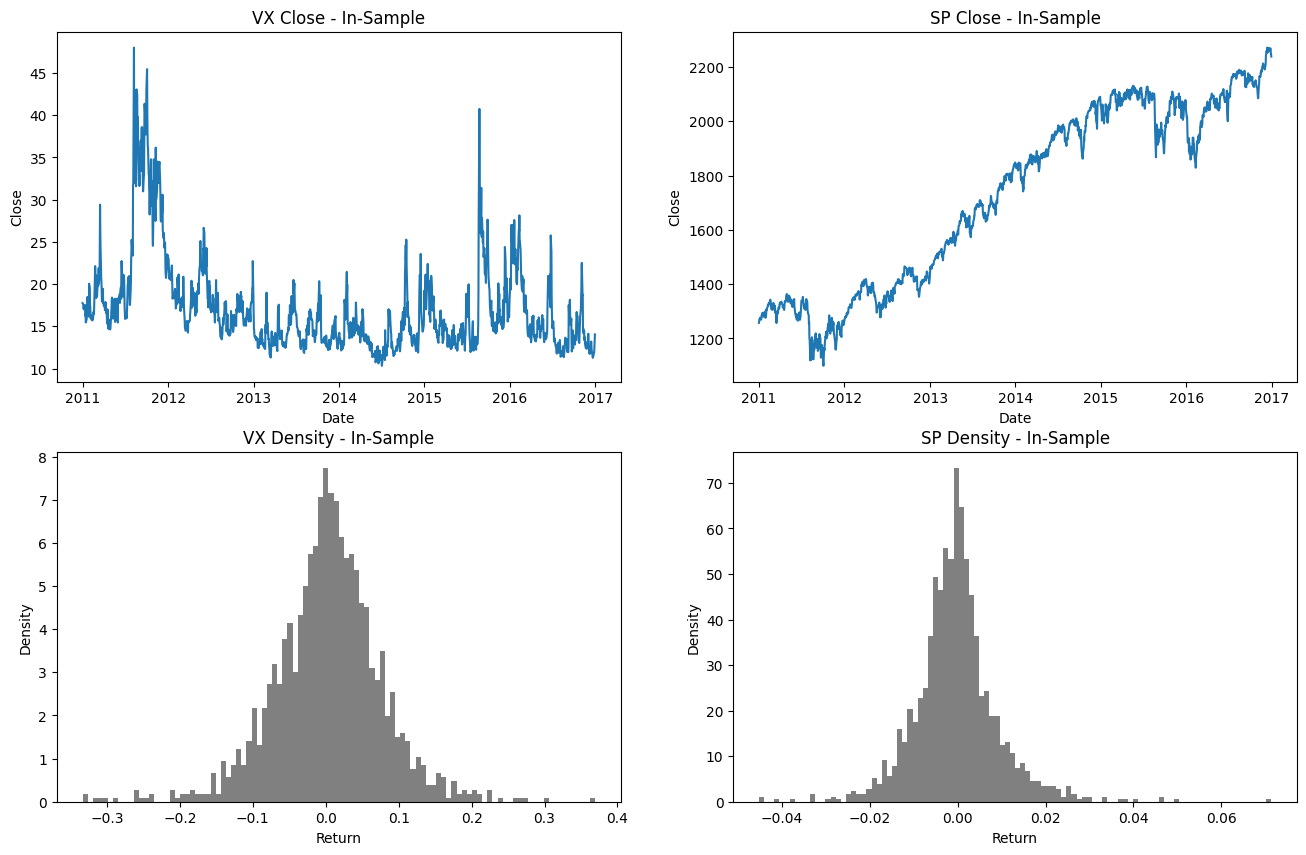

In [6]:
fig_1 = plt.figure(1, figsize=(16, 10))

#Plotting VX close prices for in-sample period
chart1 = fig_1.add_subplot(221)
chart1.plot(vx_close_is)
chart1.set_ylabel('Close')
chart1.set_xlabel('Date')
chart1.title.set_text('VX Close - In-Sample')

#Plotting SP close prices for in-sample period
chart2 = fig_1.add_subplot(222)
chart2.plot(sp_close_is)
chart2.set_ylabel('Close')
chart2.set_xlabel('Date')
chart2.title.set_text('SP Close - In-Sample')

#Plotting distribution for VX return for in-sample period
chart3 = fig_1.add_subplot(223)
chart3.hist(vx_return_is, density='True', bins=100, label='empirical', color='grey')
chart3.set_ylabel('Density')
chart3.set_xlabel('Return')
chart3.title.set_text('VX Density - In-Sample')

#Plotting distribution for SP return for in-sample period
chart4 = fig_1.add_subplot(224)
chart4.hist(sp_return_is, density='True', bins=100, label='empirical', color='grey')
chart4.set_ylabel('Density')
chart4.set_xlabel('Return')
chart4.title.set_text('SP Density - In-Sample')

plt.show()

<ipython-input-7-cd313c3fe9d9>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels([str(p.date()) for p in sp_return_is[::len(sp_return_is)//9].index])


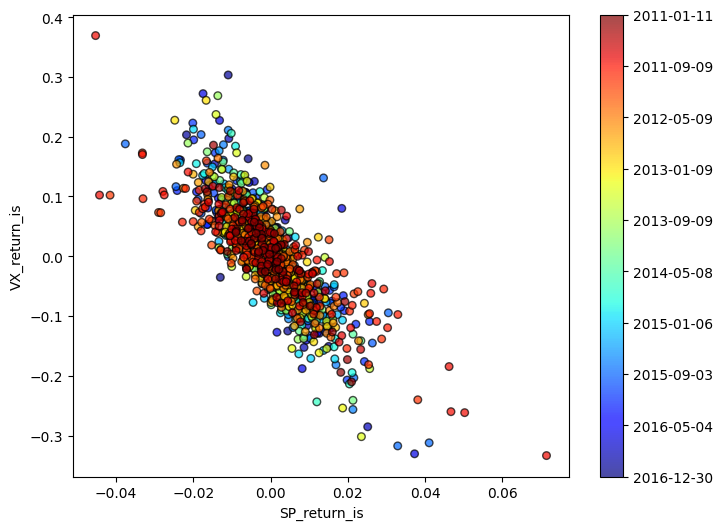

In [7]:
# Plotting VX return against SP return
plt.figure(figsize=(8,6))
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(sp_return_is))
sc = plt.scatter(sp_return_is, vx_return_is, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in sp_return_is[::len(sp_return_is)//9].index])
plt.xlabel('SP_return_is')
plt.ylabel('VX_return_is');

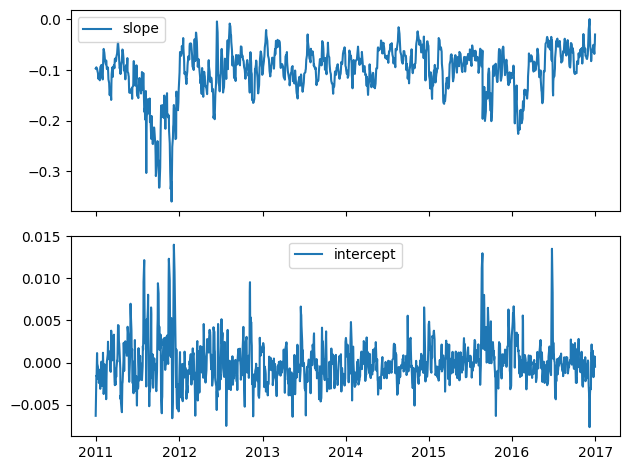

In [8]:
# Setting up KalmanFilter object
kf_is = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=np.zeros(2),
                  transition_matrices=np.eye(2),
                  observation_matrices=np.expand_dims(np.vstack([[vx_return_is], [np.ones(len(vx_return_is))]]).T, axis=1),
                  em_vars=['transition_covariance', 'observation_covariance', 'initial_state_covariance'])

# Perform EM to estimate 'transition_covariance', 'observation_covariance' and 'initial_state_covariance' using in-sample data
# Perform smoothing on in-sample data
state_means_is, state_covs_is = kf_is.em(sp_return_is).smooth(sp_return_is)

# Plotting slop and intercept. The slope is the hedge ratio we are looking for. A negative slope indicates a long position.
_, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(vx_return_is.index, state_means_is[:,0], label='slope')
axarr[0].legend()
axarr[1].plot(vx_return_is.index, state_means_is[:,1], label='intercept')
axarr[1].legend()
plt.tight_layout();

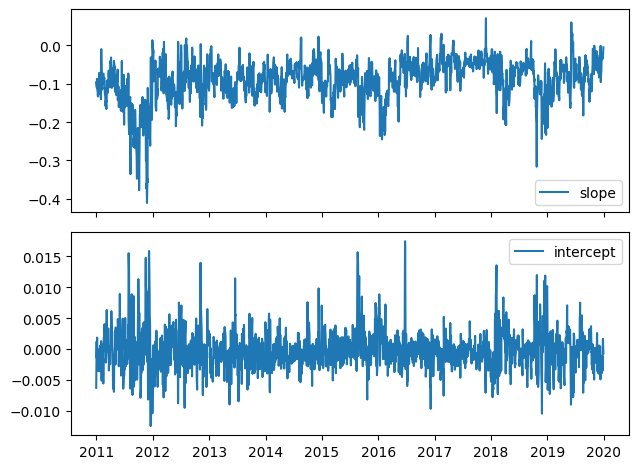

In [9]:
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=np.zeros(2),
                  transition_matrices=np.eye(2),
                  observation_matrices=np.expand_dims(np.vstack([[vx_return], [np.ones(len(vx_return))]]).T, axis=1),
                  em_vars=['transition_covariance', 'observation_covariance', 'initial_state_covariance'])

# Perform EM to estimate 'transition_covariance', 'observation_covariance' and 'initial_state_covariance' using in-sample data
# Perform filtering on all data (including both in-sample and out-of-sample)
# We would only use the hedge ratios in the out-of-sample period later when developing strategy
state_means, state_covs = kf.em(sp_return_is).filter(sp_return)

# Plotting slop and intercept. The slope is the hedge ratio we are looking for. A negative slope indicates a long position.
_, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(vx_return.index, state_means[:,0], label='slope')
axarr[0].legend()
axarr[1].plot(vx_return.index, state_means[:,1], label='intercept')
axarr[1].legend()
plt.tight_layout()

In [10]:
hedge_ratio = pd.DataFrame(state_means[:,0], index=vx_return.index, columns=['hedge_ratio'])
hedge_ratio_os = hedge_ratio[hedge_ratio.index > in_sample_last]

# Hedge ratio generated on Jan-02 is used for trading on Jan-03
hedge_ratio_os_shifted = hedge_ratio_os.shift(1)
hedge_ratio_os_shifted = hedge_ratio_os_shifted.dropna()

# Shift return such that return on Jan-03 corresponds to (close price on Jan-04 - close price on Jan-03)/close price on Jan-03
vx_return_os_shifted = vx_return_os.shift(-1)
sp_return_os_shifted = sp_return_os.shift(-1)

os_df = pd.concat([hedge_ratio_os_shifted, vx_return_os_shifted, sp_return_os_shifted], axis=1)
os_df = os_df.dropna()
os_df['sp_cumulative_return'] = os_df['sp_return'].cumsum()

os_df.head()

,hedge_ratio,vx_return,sp_return,sp_cumulative_return
data,,,,
2017-01-04,-0.094021,0.084388,-0.005690,-0.005690
2017-01-05,-0.075733,0.015424,0.000771,-0.004918
2017-01-06,-0.061328,0.030919,-0.003505,-0.008423
2017-01-09,-0.060536,-0.020761,0.003561,-0.004862
2017-01-10,-0.049744,0.006092,0.000000,-0.004862


In [11]:
os_df.to_excel('os_df.xlsx')
sp_return[sp_return.index >= in_sample_last_minus_half_year].to_csv('SP_Return_os.csv')

In [13]:
turb = pd.read_csv('Turbulence Index.csv', index_col=0)
turb.index = pd.to_datetime(turb.index)
close_df = close_df.join(turb['Close'], how='left')

# For days with missing data in daily turbulence index, we simply fill in previous values
close_df.fillna(method='ffill', inplace=True)

close_df.columns = ['vx_close', 'sp_close', 'turb_close']
close_df['turb_close'] = close_df['turb_close'].interpolate(method='linear')
turb_close = close_df['turb_close']

turb_close_is = turb_close[turb_close.index <= in_sample_last]
turb_close_os = turb_close[turb_close.index > in_sample_last]

turb_close_os.head()

<ipython-input-13-383858ac03c1>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_df.fillna(method='ffill', inplace=True)


,turb_close
data,
2019-12-31,NaN
2019-12-30,2.79233
2019-12-27,1.48309
2019-12-26,6.02802
2019-12-24,2.58912


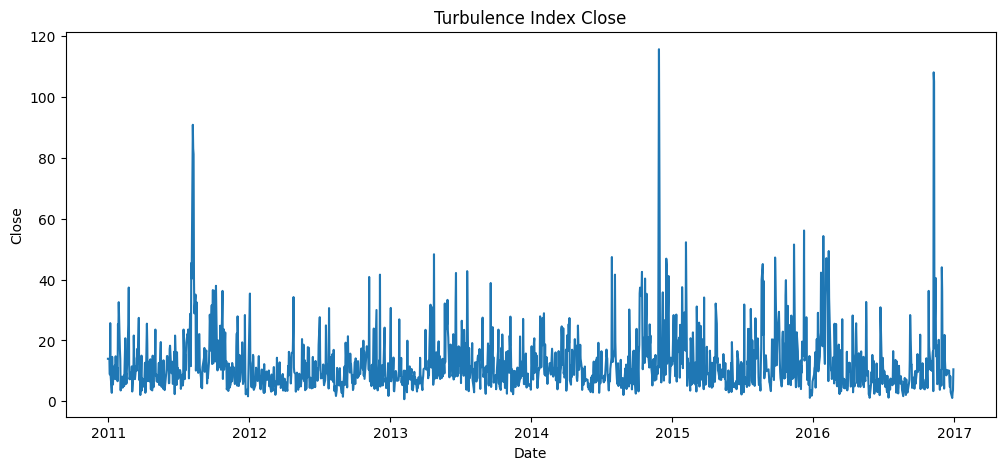

In [14]:
fig_2 = plt.figure(2, figsize=(12, 5))

chart5 = fig_2.add_subplot(111)
chart5.plot(turb_close_is)
chart5.set_ylabel('Close')
chart5.set_xlabel('Date')
chart5.title.set_text('Turbulence Index Close')

In [15]:
def forward_algo(v, mu, sigma, a, initial_distribution):
    T = len(v)
    b = np.zeros((T, 2))

    for t in range(T):
        b[t, 0] = np.exp(-0.5 * ((v[t]-mu[0][0])/sigma[0][0])**2)/np.sqrt(2*math.pi)/sigma[0][0]
        b[t, 1] = np.exp(-0.5 * ((v[t]-mu[0][1])/sigma[0][1])**2)/np.sqrt(2*math.pi)/sigma[0][1]

    forward = np.zeros((v.shape[0], a.shape[0]))
    scale = np.zeros((v.shape[0], a.shape[0]))
    forward[0, :] = b[0, :] * initial_distribution
    scale[0, :] = np.sum(forward[0, :])
    forward[0, :] = forward[0, :]/np.sum(forward[0, :])
    for t in range(1, T):
        forward[t, :] = forward[t-1, :].dot(a) * b[t, :]
        scale[t, :] = np.sum(forward[t, :])
        forward[t, :] = forward[t, :]/np.sum(forward[t, :])

    return(forward)


def baum_welch(v, mu, sigma, a, initial_distribution):
    T = len(v)
    b = np.zeros((T, 2))

    likelihood = -999
    change_likelihood = 999
    tolerance = 0.001

    while change_likelihood > tolerance:
        for t in range(T):
            b[t, 0] = np.exp(-0.5 * ((v[t]-mu[0][0])/sigma[0][0])**2)/np.sqrt(2*math.pi)/sigma[0][0]
            b[t, 1] = np.exp(-0.5 * ((v[t]-mu[0][1])/sigma[0][1])**2)/np.sqrt(2*math.pi)/sigma[0][1]

        forward = np.zeros((v.shape[0], a.shape[0]))
        scale = np.zeros((v.shape[0], a.shape[0]))
        forward[0, :] = b[0, :] * initial_distribution
        scale[0, :] = np.sum(forward[0, :])
        forward[0, :] = forward[0, :]/np.sum(forward[0, :])
        for t in range(1, T):
            forward[t, :] = forward[t-1, :].dot(a) * b[t, :]
            scale[t, :] = np.sum(forward[t, :])
            forward[t, :] = forward[t, :]/np.sum(forward[t, :])

        backward = np.zeros((v.shape[0], a.shape[0]))
        backward[-1, :] = b[-1: ]
        backward[-1, :] = backward[-1, :]/sum(backward[-1, :])
        for t in range(T-2, -1, -1):
            backward[t, :] = (a.dot(backward[t+1, :].T)).T * b[t+1, :]
            backward[t, :] = backward[t, :]/np.sum(backward[t, :])

        smoothed = np.zeros((v.shape[0], a.shape[0]))
        for t in range(T):
            smoothed[t, :] = forward[t, :] * backward[t, :]
            smoothed[t, :] = smoothed[t, :]/np.sum(smoothed[t, :])

        xi = np.zeros((2, 2, T-1))
        for t in range(T-1):
            xi[:, :, t] = a * (np.array([forward[t, :]]).T.dot(np.array([backward[t+1, :] * b[t+1, :]])))
            xi[:, :, t] = xi[:, :, t]/np.sum(np.sum(xi[:, :, t], axis=1))

        p = smoothed[0, :]
        exp_num_transition = np.sum(xi, axis=2)
        a[0, :] = exp_num_transition[0, :]/np.sum(smoothed[1:T, :])
        a[1, :] = exp_num_transition[1, :]/np.sum(smoothed[1:T, :])
        mu[0][0] = (smoothed[:, 0].T.dot(v)).T/np.sum(smoothed[:, 0])
        mu[0][1] = (smoothed[:, 1].T.dot(v)).T/np.sum(smoothed[:, 1])
        sigma[0][0] = np.sqrt(np.sum(smoothed[:, 0] * (v-mu[0][0]) ** 2)/np.sum(smoothed[:, 0]))
        sigma[0][1] = np.sqrt(np.sum(smoothed[:, 1] * (v-mu[0][1]) ** 2)/np.sum(smoothed[:, 1]))

        tmp_likelihood = np.sum(np.sum(np.log(scale)))
        change_likelihood = np.abs(tmp_likelihood - likelihood)
        likelihood = tmp_likelihood

    return mu, sigma, a


In [16]:
# Calibrating the Markow Switching Model using the Baum Welch Algorithm
v = turb_close_is.values
mu = np.mean(v) + np.std(v) * np.random.randn(1,2)
sigma = np.zeros((1,2)) + np.std(v)
a = np.ones((2, 2))
a = a / np.sum(a, axis=1)
initial_distribution = np.array((0.5, 0.5))
mu_bw, sigma_bw, a_bw = baum_welch(v, mu, sigma, a, initial_distribution)

# Infer the probabilities for high volatility regime and low volatility regime using the Forward Algorithm
regime_prob_array = forward_algo(turb_close.values, mu_bw, sigma_bw, a_bw, initial_distribution)
regime_prob_df = pd.DataFrame(regime_prob_array, index=turb_close.index)
regime_prob_df.columns = ['Regime_0', 'Regime_1']
regime_prob_df = regime_prob_df.join(turb_close, how='left')

# Simply to find out whether regime_0 or regime_1 correpsonds to the high volatility regime
signal = regime_prob_df['Regime_0'] > regime_prob_df['Regime_1']
if (regime_prob_df['turb_close'][signal]).mean() > (regime_prob_df['turb_close'][~signal]).mean():
    regime_prob_df['hmm_signal'] = signal
else:
    regime_prob_df['hmm_signal'] = ~signal

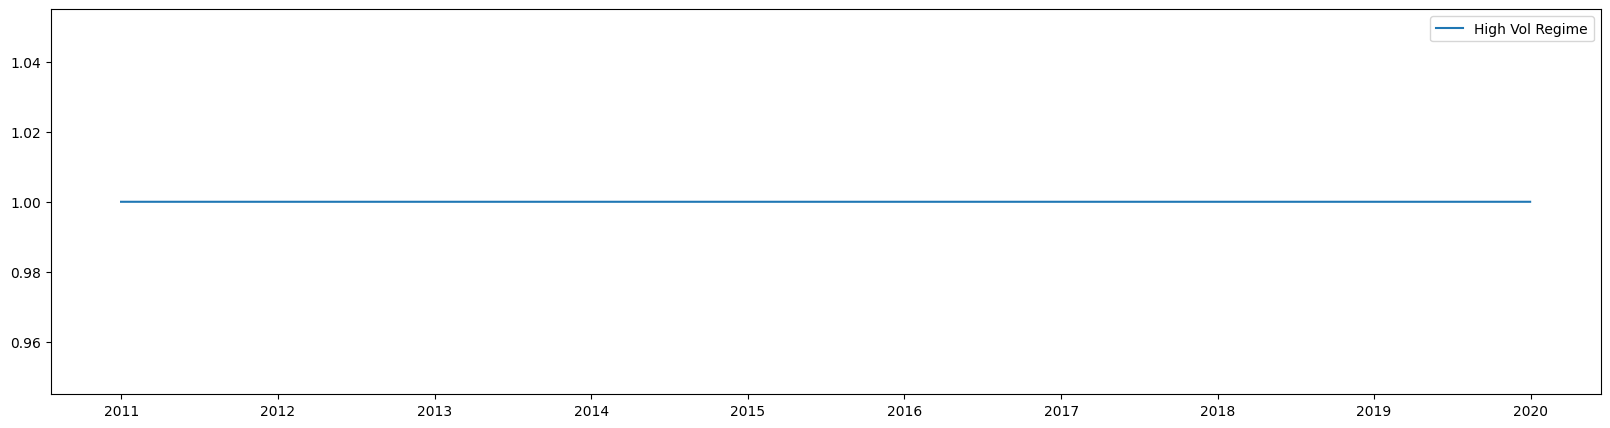

In [17]:
regime_prob_df.columns
plt.figure(figsize=(20,5))
plt.plot(regime_prob_df['hmm_signal'], label='High Vol Regime')
plt.legend(loc="upper right")

In [18]:
# Regime signal generated on Jan-02 is used for trading on Jan-03
hmm_signal = regime_prob_df['hmm_signal'].shift(1)
hmm_signal = hmm_signal.dropna()

os_df = os_df.join(hmm_signal).join(turb_close).join(sp_close)
os_df = os_df
os_df.head()

,hedge_ratio,vx_return,sp_return,sp_cumulative_return,hmm_signal,turb_close,sp_close
data,,,,,,,
2017-01-04,-0.094021,0.084388,-0.005690,-0.005690,True,13.81766,2270.75
2017-01-05,-0.075733,0.015424,0.000771,-0.004918,True,6.79033,2269.00
2017-01-06,-0.061328,0.030919,-0.003505,-0.008423,True,10.97479,2276.98
2017-01-09,-0.060536,-0.020761,0.003561,-0.004862,True,9.61197,2268.90
2017-01-10,-0.049744,0.006092,0.000000,-0.004862,True,7.74297,2268.90


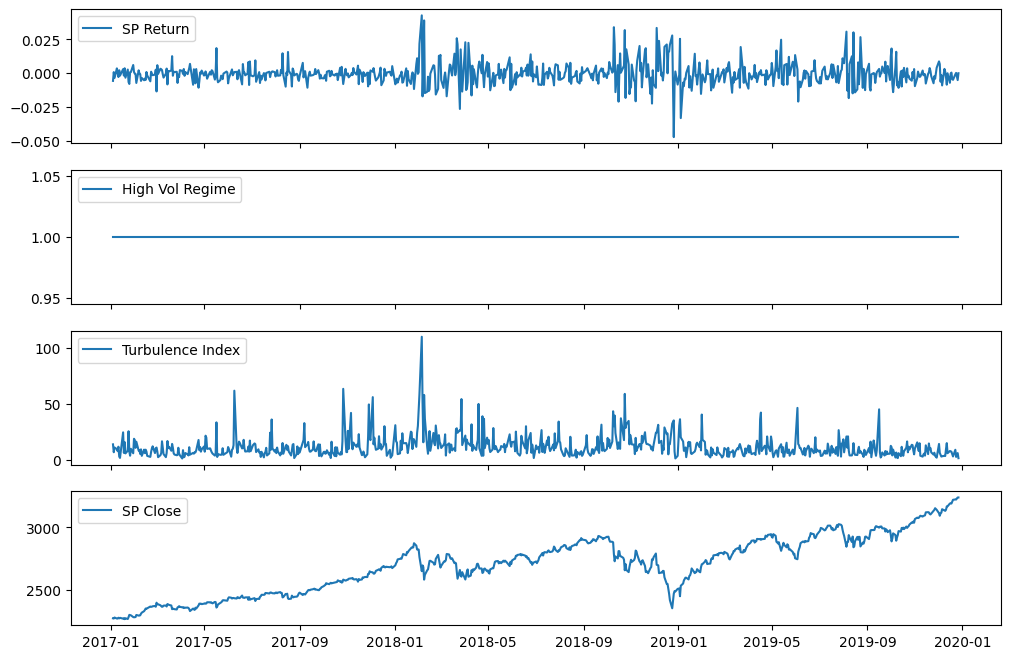

In [19]:
_, axarr = plt.subplots(4, sharex=True, figsize=(12,8))

# Plotting daily return for S&P 500 Futures
axarr[0].plot(os_df.index, os_df['sp_return'], label='SP Return')
axarr[0].legend(loc='upper left')

# Plotting regime signal generated from HMM model
axarr[1].plot(os_df.index, os_df['hmm_signal'], label='High Vol Regime')
axarr[1].legend(loc='upper left')

# Plotting Turbulence Index
axarr[2].plot(os_df.index, os_df['turb_close'], label='Turbulence Index')
axarr[2].legend(loc='upper left')

# Plotting close price for S&P 500 Futures
axarr[3].plot(os_df.index, os_df['sp_close'], label='SP Close')
axarr[3].legend(loc='upper left')

plt.show()

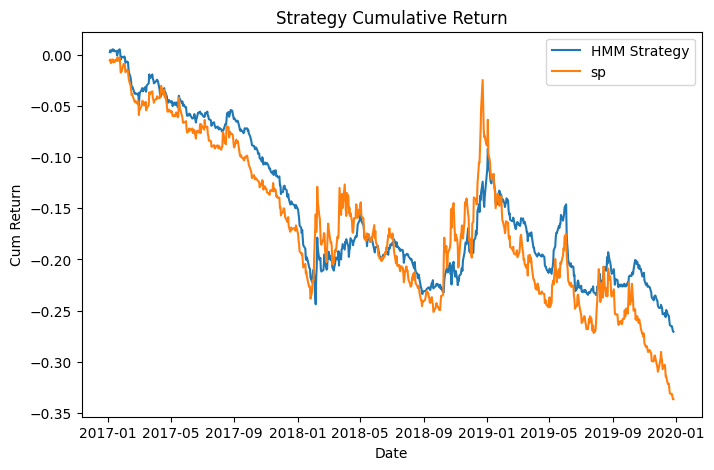

In [20]:
# Calculating strategy return
os_df['hmm_strategy_return'] = os_df['sp_return'] - os_df['hmm_signal'] * os_df['hedge_ratio'] * os_df['vx_return']
os_df['hmm_strategy_cumulative_return'] = os_df['hmm_strategy_return'].cumsum()

# PLotting cummulative return for HMM strategy against benchmark portfolio of longing S&P 500 Futures
fig_2 = plt.figure(1, figsize=(8, 5))

chart5 = fig_2.add_subplot(111)
chart5.plot(os_df['hmm_strategy_cumulative_return'], label='HMM Strategy')
chart5.plot(os_df['sp_cumulative_return'], label='sp')
chart5.set_ylabel('Cum Return')
chart5.set_xlabel('Date')
chart5.title.set_text('Strategy Cumulative Return')
chart5.legend(loc='upper right', fontsize=10)
plt.show()